> ### EEE4423: Signal Processing Lab

# LAB \#5: Limitation: Spatial Transformer Network(STN)

<h4><div style="text-align: right"> Due date:  </div> <br>
<div style="text-align: right"> Please upload your file @ yscec by 9 PM in the form of [ID_Name_Lab5.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">2014142243 차현수</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2021-06-19 17:25:55.595424


## Spatial Transformer Network for classification of distorted MNIST dataset

## Spatial Transformer Network(STN) [1]
>- CNNs are limited by the lack of ability to be spatially invariant to the input data
>- Learnable module which explicitly allows the spatial manipulation of data within the network
>- This differentiable module can be inserted into existing convolutional architectures

<img src="https://docs.google.com/uc?export=download&id=1GV2Ix6wuikWdq6-tGkZv2vMQbqMokDbf" alt="no_image" style="width: 900px;"/>

### STN module
>1. Localization Network
>>- With given input feature map, this network outputs the parameters of the spatial transformation (e.g. 6 parameters for affine transformation)
>>- Reference for affine transformation : [2],[3] <br>
>> <img src="https://docs.google.com/uc?export=download&id=1qho08Gzea5qDTpmsnii0rvwiLzwy54K6" alt="no_image" style="width: 900px;"/>

>2. Parameterised sampling grid (Grid generator)
>>- Set of points where the input feature map is sampled to produce the transformation which is a output of localization network  
>>- Target coordinate and source coordinate are normalised ($ -1\le(x_i^t, y_i^t)\le1$,$ -1\le(x_i^s, y_i^s)\le1$ )
<img src="https://docs.google.com/uc?export=download&id=1pRWzwevo1KjWi3WIC4K8SCkK4oYCD7FZ" alt="no_image" style="width: 500px;"/>
>3. Differentiable Image Sampling (Sampler)
>>- Ouput feature map is produced by differentiable bilinear interpolation with input feature map and parameterised sampling grid
    
<img src="https://docs.google.com/uc?export=download&id=1EjoZ6CVLTD3QNl1CKbg1w3YiNf1CzOmH" alt="no_image" style="width: 900px;"/>


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import io
import requests
import os 
import copy
import time
%matplotlib inline

In [3]:
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'GeForce RTX 3090'

In [4]:
# parameters

batch_size = 256
learning_rate = 0.001
num_epoch = 60
num_classes = 10


### 1. Dataset (Distorted MNIST, details in Appendix A.4 Distorted MNIST) [1point]
>- Generate RTS(rotated, translated, scaled) MNIST 
>>- Use *torchvision.transforms*
>>- Randomly rotating between $-45^\circ, 45^\circ$
>>- Randomly scaling the digit by a factor of between $0.7,1.2$
>>- Placing the digit in a random location in a $40\times40$ region of image's center
>>- Zerp padding to increase image's size for the digit's translation ($80\times80$ image)
>>- Images to tensor 
>>- Normalize data with MNIST dataset's mean and standard deviation printed in the 5th cell below


#### 1.1 Write codes for dataset's transformation [1 point]


In [5]:
import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [6]:
print('STEP 1: DEFINE DATASET')

import random
train_dataset = dset.MNIST("./data/mnist", train=True,
                        #############
                        # CODE HERE #
                        transform=transforms.Compose([
                            # Randomly Rotating between -45 to 45 degree
                            # Randomly scaling between 0.7 to 1.2
                            transforms.RandomAffine(degrees=(-45, 45), scale=(0.7, 1.2)),
                            # Randomly located in a 40 x 40 region of image's centre
                            transforms.RandomCrop(80, padding=40),
                            # Zero Padding to increase image's size to 80 x 80
                            transforms.CenterCrop(80),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]),
                        #############
                        target_transform=None,
                        download=True)
test_dataset = dset.MNIST("./data/mnist", train=False,
                        #############
                        # CODE HERE #
                        transform=transforms.Compose([
                            transforms.RandomAffine(degrees=(-45, 45), scale=(0.7, 1.2)),
                            transforms.RandomCrop(80, padding=40),
                            transforms.CenterCrop(80),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]),
                        #############
                        target_transform=None,
                        download=False)

train_size = len(train_dataset)
test_size = len(test_dataset)

#dataset mean and std for normalization
print('MNIST mean: ',train_dataset.train_data.float().mean()/255)
print('MNIST std: ',train_dataset.train_data.float().std()/255)

STEP 1: DEFINE DATASET
MNIST mean:  tensor(0.1307)
MNIST std:  tensor(0.3081)


/home/stephencha/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [7]:
print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))


Train dataset size: 60000
Test dataset size: 10000


###  Visualize Dataset


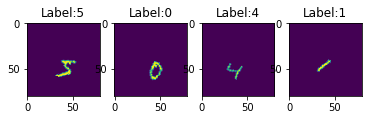

In [8]:
figure = plt.figure()

for i in range(train_size):
    sample = train_dataset[i]
    figure.add_subplot(1,4,i+1).set_title('Label:{}'.format(sample[1]))
    imgplot = plt.imshow((sample[0].squeeze(0).cpu()+1)/2)
    if i == 3:
        plt.show()
        break

In [9]:
print('STEP 2: LOADING DATASET')

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=4,drop_last=True)

STEP 2: LOADING DATASET


##  Model
### 2. CNN Model Setup (details in Appendix A.4 Distorted MNIST) [3points]
>
>1. CNN 
>>- 2 convolutional layers and 2 max-pooling layers before final classification layer
>>- Two conv layers have 32 and 64 filters and use ReLU 
>2. Classifier
>>- 2 fully-connected layers and the number of input features to the last layer is 128
>>- Also use ReLU as an activation function
>3. ST module
>>- At the beginning of the network
>>- 2 convolutional layer and 2 fully-connected layer in localization network
>>- Initialize the *fc_loc*'s final regression layer with identity transformation
>>- Produce affine transformation parameters for RTS dataset
>>- Reference for grid generator function: [4] <br>
>>- Reference for sampler function: [5] <br>
>
> **++Hint: All learnable parameters' sizes of model are in the 10th cell below** <br>
> **++For RTS datasets, the network has average pooling layer after the ST module to downsample the output of the transformer by a factor of 2**

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| 1st Conv of *cnn* | 9 | 1 | 0 |
| 2nd Conv of *cnn* | 7 | 1 | 0 |
| 1st Conv of *localization* | 5 | 1 | 0 |
| 2nd Conv of *localization* | 5 | 1 | 0 |
| AvgPool | 2 | 2 | 0 |
| MaxPool | 2 | 2 | 0 |


#### 2.1 Write codes for the model class (STN_CNN) [3 points]


In [10]:
print('STEP 3: CREATE MODEL CLASS (STN_CNN)')
        
class STN_CNN(nn.Module):
    #############
    # CODE HERE #
    def __init__(self):
        super(STN_CNN, self).__init__()
        # CNN Module
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=9, stride=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7, stride=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(1600, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
        # Localization-network (Spatial transformer)
        self.localization = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, stride=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Dropout2d(),
            nn.Conv2d(20, 20, kernel_size=5, stride=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
        )
        # Regressor (for Affine Matrix)
        self.fc_loc = nn.Sequential(
            nn.Linear(in_features=17 * 17 * 20 * 4, out_features=20),
            nn.ReLU(True),
            nn.Linear(20, 3 * 2)
        )
        # Initialize
        self.fc_loc[2].weight.data.zero_()
        # identity transformation.
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        self.avg = nn.AvgPool2d(kernel_size=2, stride=2)
    
    # ST Network Module
    def stmodule(self, x, im_size):
        x_loc = self.localization(x)
        # torch.Size([256, 20, 17, 17])
        x_viewloc = x_loc.view(-1, 17*17*20*4)
        theta = self.fc_loc(x_viewloc)
        theta = theta.view(-1, 2, 3)
        x = x.view(im_size, -1, 80, 80)
        grid_out = F.affine_grid(theta, x.size())
        out = F.grid_sample(x, grid_out)
        return out, theta

    def forward(self, x):
        # 1st, Spatial Transformer Model
        # torch.Size([256, 1, 80, 80])
        out, theta = self.stmodule(x, im_size=64)
        # At the end of the ST Module, enter the average pooling layer
        out = self.avg(out)
        # Change Dimension
        print(out.size())#torch.Size([64, 4, 40, 40])
        out = out.view(256, 1, 40, 40)
        # Regular CNN Model
        out = self.cnn(out)
        out = out.view(-1, 1600)
        out = self.classifier(out)
        # Reduce softmax loss.
        out = F.log_softmax(out, dim=1)
        
        return out, theta
    #############

STEP 3: CREATE MODEL CLASS (STN_CNN)


In [11]:
print('STEP 4: INSTANTIATE MODEL CLASS\n')
model = STN_CNN()

print("STN_CNN's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

STEP 4: INSTANTIATE MODEL CLASS

STN_CNN's state_dict:
cnn.0.weight 	 torch.Size([32, 1, 9, 9])
cnn.0.bias 	 torch.Size([32])
cnn.3.weight 	 torch.Size([64, 32, 7, 7])
cnn.3.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])
localization.0.weight 	 torch.Size([20, 1, 5, 5])
localization.0.bias 	 torch.Size([20])
localization.4.weight 	 torch.Size([20, 20, 5, 5])
localization.4.bias 	 torch.Size([20])
fc_loc.0.weight 	 torch.Size([20, 23120])
fc_loc.0.bias 	 torch.Size([20])
fc_loc.2.weight 	 torch.Size([6, 20])
fc_loc.2.bias 	 torch.Size([6])


###  Parameter updates
#### Scheduling (Annealing) the learning rate [6]
>- In training deep networks, it is usually helpful to anneal the learning rate over time
>>- With high learning rate, the optimizing system can't settle down into deeper parts of the loss function
>- When to decay can be tricky
>>- Slowly : Wasting computation with little improvement for a long time
>>- Aggressively: Cooling too quickly, unable to find the best point
>- 3 common types
>>1. Step decay: Reduce the learning rate by some factor every few epochs (e.g. half every 5 epochs, or by 0.1 every 10 epochs)
>>2. Exponential decay: In the form of mathematical formulation $\alpha = \alpha_0\exp^{-kt}$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number(or units of epochs)
>>3. $1/t$ decay : In the form of mathematical formulation $\alpha = \alpha_0/(1+kt)$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number
>- In practice, the step decay is slightly preferable

#### How to adjust learning rate in pytorch [7]
>- *torch.optim.lr_scheduler* provides several methods based on the number of epochs
>- For example, the step decay can be implemented by *torch.optim.lr_scheduler.StepLR* class (See reference for more types)
>- We use *ReduceLROnPlateau* class in this lab which allows dynamic learning rate adjusting based on our validation measurements
>>- Reduce the learning rate when our metric has stopped improving 
>>- The learning rate is reduced if no improvement of our metric is seen for a 'patience' number of epochs
>>- See reference for more details 


In [12]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

STEP 5: INSTANTIATE OPTIMIZER CLASS


### 3.Train/Test [2points]


#### 3.1Tirain the STN_CNN model and print accuracy for every epochs [2 points]


In [13]:
print('STEP 6: INSTANTIATE LOSS CLASS')
#############
# CODE HERE #
# I will use NLLLoss, the code embeded already in STEP 7 and STEP 3 at the end of the Class.
#############

# Model to GPU
model.to(device0)


print('STEP 7: TRAIN THE MODEL')
import os                                      
file = './best_model_STN.tar'

if os.path.isfile(file):
    os.remove(file)

print(train_size)
best_acc = 0
theta_list = []
for epoch in range(num_epoch):
    #TRAIN
    model.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        
        #############
        # CODE HERE #
        img, label = img.to(device0), label.to(device0)
        optimizer.zero_grad()
        output, theta = model(img)
        theta_list.append(theta)
        loss = F.nll_loss(output, label)
        loss.backward()
        optimizer.step()
        #############
        
        
        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
           
                    
    #Test
    model.eval()
    #############
    # CODE HERE #
    loss = 0
    correct = 0
    for img, label in test_loader:
        img, label = img.to(device0), label.to(device0)
        output, _ = model(img)

        # Sum of all of loss values
        loss += F.nll_loss(output, label, size_average=False).item()
        prediction = output.max(1, keepdim=True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        
    accuracy = 100. * correct / len(test_loader.dataset)
    loss /= len(test_loader.dataset)
    print('\nTest set accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset), accuracy))
    
    #############
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './best_model_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)
#print(theta[0])
#print(theta[-1])
print("Finish Calculation")

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
60000


/home/stephencha/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/stephencha/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.301237  
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 40, 40])
torch.Size([256, 1, 40, 40])
torch.Size([64, 4, 4

KeyboardInterrupt: 

### 4. Visualize original inputs and transformed inputs with best pre-trained model  [3points]


In [ ]:
model = STN_CNN()
checkpoint = torch.load('./best_model_STN.tar') # torch.load('./pretrain/lab5/best_model_STN.tar')
model.load_state_dict(checkpoint['model_state_dict'])

#### Our pretrained model's best accuracy


In [ ]:
print('Best accuracy of our model with ST module: ', checkpoint['accuracy'])

In [ ]:
# Tensor image to array image

def reprocess_image(img):
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    mean = [-0.1307,-0.1307,-0.1307]
    std = [1/0.3081,1/0.3081,1/0.3081]
    
    for c in range(3):
        img_re[c,:,:] /= std[c]
        img_re[c,:,:] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    
    img_re = img_re.transpose(1,2,0)
    
    return img_re


#### 4.1 Write codes for visualization of original inputsa and transformed inputs [3 points]
>- VisualizeSTN class with an input of our pretrained model
>- *forward_stn*: Forward pass of our pretrained STN module to produce transformed inputs
>- *visualize*: Visualizing the original inputs and the transformed ones in a grid 
>>1. Forward pass of STN module to produce the transformed inputs
>>2. Unnormalize both images using *reprocess_image* function
>>3. Make grids of them 
>>4. Visualize 


In [ ]:
class VisualizeSTN():
    
    def __init__(self, model):
        self.model = model
        self.model.to(device0)
        self.model.eval()
    
    # Output transformed inputs
    def forward_stn(self, img):
        #############
        # CODE HERE #
        # Perform the usual forward pass
        # Get a theta of training data
        transform_input, theta = self.model.stmodule(img, im_size=4)
        #print(theta)
        transform_input = transform_input.view(16, -1, 80, 80)
        return transform_input
        #############
    
    def visualize(self, img):
        #############
        # CODE HERE #
        trans_t = self.forward_stn(img)
        # by using reprocess function, make unnormalization
        grid_in = reprocess_image(v_utils.make_grid(img, nrow=4))
        grid_out = reprocess_image(v_utils.make_grid(trans_t, nrow=4))
        
        f, ax = plt.subplots(1, 2)
        ax[0].imshow(grid_in)
        ax[0].set_title('Original images')
        ax[1].imshow(grid_out)
        ax[1].set_title('Transformed images')
        #############
        

In [ ]:
visualize_stn = VisualizeSTN(model)
for i, (image,label) in enumerate(test_loader):
    
    img = image[:16].to(device0)
    visualize_stn.visualize(img)
    
    if (i+1) == 3:
        break


### 5.Comparison with the cnn model without ST module [1point]
>- Model composed of cnn and classifier modules same with our pretrained CNN_STN model 
>- Use *cnn* and *classifier* modules you implemented 


#### 5.1 Write codes for the model class

In [ ]:
#############
# CODE HERE #

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # CNN Module
        # Same as upper model
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=9, stride=1),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7, stride=1),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(1600, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(-1, 1600)
        out = self.classifier(out)
        out = F.log_softmax(out, dim=1)
        out = out.view(256, -1)
        return out
#############

In [ ]:
model_nostn = CNN()

print("CNN's state_dict:")
for param_tensor in model_nostn.state_dict():
    print(param_tensor, "\t", model_nostn.state_dict()[param_tensor].size())

In [ ]:
optimizer = torch.optim.Adam(model_nostn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#### 5.2 Train/Test

In [ ]:
#############
# CODE HERE #
model_nostn.to(device0)

best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model_nostn.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        img, label = img.to(device0), label.to(device0)
        optimizer.zero_grad()
        output = model_nostn(img)
        loss = F.nll_loss(output, label)
        loss.backward()
        optimizer.step()
        
        if j % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
                    
    #Test
    model_nostn.eval()
    loss = 0
    correct = 0
    for img, label in test_loader:
        img, label = img.to(device0), label.to(device0)
        output = model_nostn(img)
        
        loss += F.nll_loss(output, label, size_average=False).item()
        prediction = output.max(1, keepdim=True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        
    accuracy = 100. * correct / len(test_loader.dataset)
    loss /= len(test_loader.dataset)
    print('\nTest set accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset),accuracy))
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    if accuracy > best_acc :
        best_acc = accuracy
    
    scheduler.step(accuracy)
print("Finish Calculation")

#############

#### Best accuracy of the model_nostn without ST module


In [ ]:
print('Best accuracy of our model_nostn without ST module: ', best_acc)

> Result report by written Cha, Hyunsoo

Analyze Algorithm
======
This experiment is a direct implementation of the Spatial Transformer Network. CNN alone has certain limitations in finding distorted handwriting data. To overcome these limitations, a spatial transducer has been fabricated in DeepMind. Space converters are simpler than I think. 

First, the distorted MNIST dataset passes through the localization network. I use affine transformations to calculate how distorted this image is and which values can be corrected by matrix computation. A total of six parameters exist, and the unchanging matrix is equal to the same matrix. A total of nine transformations exist, and six parameter values learned through the Localization Network allow mine to estimate how distorted the data is. The functions provided by Pytorch can then be used to implement Grid Generator and Sampler. The Localization network, Grid generator, and sampler are usually called the Spatial Transformer Network Module. Through this module, distorted MNIST dataset serves as a spatial transformation to make it easier for CNN Networks to recognize. In the rest of the network, CNN and classifier networks are implemented.

Entering the network in detail is as follows. The Localization Network stacks two convolutional layers, and also uses the max pooling layer and dropout, and the relu function. The reason for adding dropout layers was to prevent excessive tuning. The image passed through the Localization Network passes through fc_loc. A network for regressor of affine matrix. It consists of two full-connected layers. This results in estimating theta value and based on it, I modify the distorted MNIST Dataset to allow CNN to estimate with higher accuracy. Two convolutional layers, two maxpooling layers, and a relu via CNN network then the network proceeds to learn.

The values can be estimated after passing through the Full-Connected layer via the Classifier. I implemented it in a way that minimizes loss through log softmax. Optimization was carried out using Adam optimizer. 

Report & Discussion
======
Accuracy results using the STN module were approximately 98%. The accuracy of CNN networks without STN modules differed significantly in the 71% range. Visualization was conducted to see if the space converter worked properly, but the conversion was not as much as expected. Changes in size and angle were observed somewhat, but they were not dramatic. This reason appears to be a poor estimation of Theta values. As a result of tracking directly through print statements to examine changes in Theta values, Theta matrices showed some tendency similar to Identity matrices. In other words, it is natural that the human eye does not feel much of a difference in view even if space is transformed through the Theta matrix. Then I also need to think about why Theta values did not show much difference. In one's opinion, Batch size is considerably large at 256, which leads to some errors in the transformation of dimensions between networks. To equate each layer and function and dimension, I use the view function more than other models, which I estimate resulted in poor accuracy in estimating. Batch size was given in the task and thus could not be modified, and based on a deeper understanding, it should be able to derive high accuracy while using fewer view functions.

For reference, I observed an improvement of 2% in accuracy when the Dropout function was applied to CNN without the Dropout function compared to accuracy. In addition, for the second model, Only CNN model, I were able to achieve significantly higher accuracy compared to the past with 10% to 70% accuracy. In other words, the use of the dropout function to avoid excessive tuning in the network has resulted in the dropout rather disrupting the computation.

### *References*
[1] https://arxiv.org/pdf/1506.02025.pdf <br>
[2] https://en.wikipedia.org/wiki/Affine_transformation <br>
[3] https://en.wikipedia.org/wiki/Transformation_matrix#Affine_transformations <br>
[4] https://pytorch.org/docs/stable/nn.html#affine-grid <br>
[5] https://pytorch.org/docs/stable/nn.html#torch.nn.functional.grid_sample <br>
[6] http://cs231n.github.io/neural-networks-3/#anneal <br>
[7] https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate <br>